In [1]:
# ===== 1️⃣ Imports =====
import os
import time
import pickle
import random
import numpy as np
import pandas as pd
import torch

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

In [2]:
# ===== 2️⃣ Paths / Config =====
DATA_DIR = "../data"
RAW_DATA = "../datasets/heart_disease_uci.csv"
Xy_train_res_path = os.path.join(DATA_DIR, "Xy_train_resampled.csv")
os.makedirs(DATA_DIR, exist_ok=True)

STATE_DTYPE = np.float32
NUM_ACTIONS = 5    # Adjust: 2 for binary, 5 for 0-4 multiclass
NUM_EPOCHS = 150
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Model save locations
MODEL_ORIG_PTH = os.path.join(DATA_DIR, "dqn_original.pth")
MODEL_RES_PTH = os.path.join(DATA_DIR, "dqn_resampled.pth")
MODEL_ORIG_PKL = os.path.join(DATA_DIR, "dqn_original.pkl")
MODEL_RES_PKL = os.path.join(DATA_DIR, "dqn_resampled.pkl")

In [3]:
# ===== 3️⃣ Feature columns =====
feature_cols = [
    'age', 'trestbps', 'chol', 'fbs', 'thalch', 'exang', 'oldpeak',
    'sex_Male',
    'cp_atypical angina', 'cp_non-anginal', 'cp_typical angina',
    'restecg_normal', 'restecg_st-t abnormality',
    'slope_flat', 'slope_upsloping'
]


In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score

# ===== Load test set =====
X_test_df = pd.read_csv("/Users/ellaforss/git/RTDS_group/data/X_test.csv")
y_test = pd.read_csv("/Users/ellaforss/git/RTDS_group/data/y_test.csv")["num"].values

# ===== Create test DataFrame =====
df_test = X_test_df.copy()
df_test['true'] = y_test

# ===== Create age groups =====
bins = [0, 40, 50, 60, 120]  # upper bound above max age
labels = ['<=40', '41-50', '51-60', '>60']
df_test['age_group'] = pd.cut(df_test['age'], bins=bins, labels=labels, right=True)

# ===== Attach original DQN predictions =====
df_test['pred'] = res_orig["preds"]  # must match length of df_test

# ===== Settings =====
desired_order = ['<=40', '41-50', '51-60', '>60']
NUM_ACTIONS = len(np.unique(df_test['true']))
age_colors = plt.cm.viridis(np.linspace(0.3, 0.8, len(desired_order)))

# ===== Compute metrics per age group =====
acc_by_age = []
f1_by_age = []
cum_correct_by_age = []
pred_rates_by_age = []

for g in desired_order:
    mask = df_test['age_group'] == g
    y_true = df_test.loc[mask, 'true']
    y_pred = df_test.loc[mask, 'pred']

    acc_by_age.append(accuracy_score(y_true, y_pred))
    f1_by_age.append(f1_score(y_true, y_pred, average='macro'))
    cum_correct_by_age.append(np.cumsum((y_pred==y_true).astype(int)))
    pred_rates_by_age.append([(y_pred==c).mean() for c in range(NUM_ACTIONS)])

# ===== 1️⃣ Accuracy by Age Group =====
plt.figure(figsize=(8,4))
plt.bar(desired_order, acc_by_age, color=age_colors)
plt.ylim(0,1)
plt.ylabel("Accuracy")
plt.xlabel("Age Group")
plt.title("DQN - Accuracy by Age Group")
plt.tight_layout()
plt.show()

# ===== 2️⃣ Macro F1 by Age Group =====
plt.figure(figsize=(8,4))
plt.bar(desired_order, f1_by_age, color=age_colors)
plt.ylim(0,1)
plt.ylabel("Macro F1")
plt.xlabel("Age Group")
plt.title("DQN - Macro F1 by Age Group")
plt.tight_layout()
plt.show()

# ===== 3️⃣ Cumulative Correct Predictions =====
plt.figure(figsize=(8,4))
for g, cum, c in zip(desired_order, cum_correct_by_age, age_colors):
    plt.plot(cum, label=g, color=c)
plt.xlabel("Test Sample Index")
plt.ylabel("Cumulative Correct Predictions")
plt.title("DQN - Cumulative Correct Predictions by Age Group")
plt.legend()
plt.tight_layout()
plt.show()

# ===== 4️⃣ Prediction Distribution per Class =====
x = np.arange(NUM_ACTIONS)
width = 0.7 / len(desired_order)
plt.figure(figsize=(10,4))
for i, (g, rates, c) in enumerate(zip(desired_order, pred_rates_by_age, age_colors)):
    plt.bar(x + (i - len(desired_order)/2)*width, rates, width, color=c, label=g)
plt.xticks(x, [f'Class {c}' for c in range(NUM_ACTIONS)])
plt.ylabel("Prediction Rate")
plt.xlabel("Class")
plt.title("DQN - Prediction Distribution by Age Group")
plt.legend()
plt.tight_layout()
plt.show()


NameError: name 'res_orig' is not defined

In [ ]:
# ===== 5️⃣ Define environment =====
class CardiacEnv:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.n = len(X)

    def reset(self):
        idx = np.random.randint(0, self.n)
        return self.X[idx]

    def step(self, action):
        idx = np.random.randint(0, self.n)
        reward = 1.0 if action == self.y[idx] else 0.0
        done = True
        s2 = self.X[np.random.randint(0, self.n)]
        return s2, reward, done, {}

# ===== 6️⃣ Define DQN agent =====
class DQNAgent:
    def __init__(self, state_dim, n_actions):
        self.state_dim = state_dim
        self.n_actions = n_actions
        self.eps = 1.0
        self.q = torch.nn.Sequential(
            torch.nn.Linear(state_dim, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, n_actions)
        )
        self.optimizer = torch.optim.Adam(self.q.parameters(), lr=1e-3)
        self.memory = []

    def act(self, state, greedy=False):
        state = torch.tensor(state, dtype=torch.float32)
        if greedy or np.random.rand() > self.eps:
            with torch.no_grad():
                return int(torch.argmax(self.q(state)).item())
        else:
            return np.random.randint(self.n_actions)

    def push(self, s, a, r, s2, done):
        self.memory.append((s, a, r, s2, done))
        if len(self.memory) > 10000:
            self.memory.pop(0)

    def train_step(self):
        if not self.memory:
            return None
        s, a, r, s2, done = self.memory[-1]
        s = torch.tensor(s, dtype=torch.float32)
        s2 = torch.tensor(s2, dtype=torch.float32)
        r = torch.tensor(r, dtype=torch.float32)
        q_values = self.q(s)
        q_next = self.q(s2)
        target = r + 0.99 * torch.max(q_next) * (1 - done)
        loss = torch.nn.functional.mse_loss(q_values[a], target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss.item()

    def save(self, path):
        torch.save(self.q.state_dict(), path)

In [ ]:
# ===== 7️⃣ Training helper =====
def train_and_save(X_tr, y_tr, out_pth, out_pkl, name, num_epochs=NUM_EPOCHS):
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)

    env = CardiacEnv(X_tr, y_tr)
    agent = DQNAgent(state_dim=X_tr.shape[1], n_actions=NUM_ACTIONS)

    # Epsilon decay parameters
    eps_start = 1.0
    eps_min = 0.05
    eps_decay = 0.995  # decay per epoch
    agent.eps = eps_start

    print(f"Start training {name}: n={len(X_tr)} epochs={num_epochs}")
    t0 = time.time()
    for epoch in range(num_epochs):
        losses = []
        for _ in range(len(X_tr)):
            s = env.reset()
            a = agent.act(s, greedy=False)
            s2, r, done, _ = env.step(a)
            agent.push(s, a, r, s2, float(done))
            loss = agent.train_step()
            if loss is not None:
                losses.append(loss)

        # Decay epsilon after each epoch
        agent.eps = max(agent.eps * eps_decay, eps_min)

        if (epoch + 1) % 5 == 0 or epoch == 0:
            avg_loss = np.mean(losses) if losses else float("nan")
            print(f" {name} epoch {epoch+1}/{num_epochs} avg_loss={avg_loss:.4f} eps={agent.eps:.3f}")

    duration = time.time() - t0
    agent.save(out_pth)
    with open(out_pkl, "wb") as f:
        pickle.dump(agent.q.cpu(), f)
    print(f"Saved {name} -> {out_pth} (.pth) and {out_pkl} (.pkl)  (took {duration:.1f}s)")
    return agent


### Train model

In [ ]:
# ===== 8️⃣ Train models =====
agent_orig = train_and_save(X_train_orig, y_train_orig, MODEL_ORIG_PTH, MODEL_ORIG_PKL, "DQN_original")
agent_res = train_and_save(X_train_res, y_train_res, MODEL_RES_PTH, MODEL_RES_PKL, "DQN_resampled")


Start training DQN_original: n=736 epochs=150
 DQN_original epoch 1/150 avg_loss=0.1757 eps=0.995
 DQN_original epoch 5/150 avg_loss=0.1507 eps=0.975
 DQN_original epoch 10/150 avg_loss=0.1474 eps=0.951
 DQN_original epoch 15/150 avg_loss=0.1646 eps=0.928
 DQN_original epoch 20/150 avg_loss=0.1496 eps=0.905
 DQN_original epoch 25/150 avg_loss=0.1661 eps=0.882
 DQN_original epoch 30/150 avg_loss=0.1657 eps=0.860
 DQN_original epoch 35/150 avg_loss=0.1424 eps=0.839
 DQN_original epoch 40/150 avg_loss=0.1563 eps=0.818
 DQN_original epoch 45/150 avg_loss=0.1558 eps=0.798
 DQN_original epoch 50/150 avg_loss=0.1764 eps=0.778
 DQN_original epoch 55/150 avg_loss=0.1558 eps=0.759
 DQN_original epoch 60/150 avg_loss=0.1605 eps=0.740
 DQN_original epoch 65/150 avg_loss=0.1779 eps=0.722
 DQN_original epoch 70/150 avg_loss=0.1549 eps=0.704
 DQN_original epoch 75/150 avg_loss=0.1715 eps=0.687
 DQN_original epoch 80/150 avg_loss=0.1833 eps=0.670
 DQN_original epoch 85/150 avg_loss=0.1840 eps=0.653
 D

### Evaluations

In [ ]:
# ===== 9️⃣ Evaluation helper =====
def eval_agent(agent, X_eval, y_eval, test_sex=None):
    agent.eps = 0.0
    preds = np.array([agent.act(X_eval[i], greedy=True) for i in range(len(X_eval))])

    out = {
        "accuracy": float(accuracy_score(y_eval, preds)),
        "macro_f1": float(f1_score(y_eval, preds, average="macro")),
        "preds": preds
    }

    if test_sex is not None:
        def group_class_metrics(y_true, y_pred, groups, classes=None):
            classes = classes if classes is not None else np.unique(y_true)
            results = {}
            for g in np.unique(groups):
                idx = groups == g
                yt, yp = y_true[idx], y_pred[idx]
                res = {
                    "n": int(len(yt)),
                    "accuracy": float(accuracy_score(yt, yp)),
                    "macro_f1": float(f1_score(yt, yp, average="macro"))
                }
                for c in classes:
                    yt_bin = (yt == c).astype(int)
                    yp_bin = (yp == c).astype(int)
                    res[f"precision_class_{c}"] = float(precision_score(yt_bin, yp_bin, zero_division=0))
                    res[f"recall_class_{c}"] = float(recall_score(yt_bin, yp_bin, zero_division=0))
                    res[f"pred_rate_class_{c}"] = float((yp == c).mean())
                results[str(g)] = res
            return results
        out["metrics_by_sex"] = group_class_metrics(y_eval, preds, test_sex, classes=np.arange(NUM_ACTIONS))
    return out

# ===== 10️⃣ Evaluate models =====
res_orig = eval_agent(agent_orig, X_test, y_test, test_sex)
res_res = eval_agent(agent_res, X_test, y_test, test_sex)

print("\n== Overall Test Metrics ==")
print("Original model - accuracy:", res_orig["accuracy"], "macro_f1:", res_orig["macro_f1"])
print("Resampled model - accuracy:", res_res["accuracy"], "macro_f1:", res_res["macro_f1"])

if test_sex is not None:
    print("\n== Sex-disaggregated metrics (Original model) ==")
    for g, met in res_orig["metrics_by_sex"].items():
        print(f"Group {g}: n={met['n']}, acc={met['accuracy']:.3f}, macro_f1={met['macro_f1']:.3f}")
    print("\n== Sex-disaggregated metrics (Resampled model) ==")
    for g, met in res_res["metrics_by_sex"].items():
        print(f"Group {g}: n={met['n']}, acc={met['accuracy']:.3f}, macro_f1={met['macro_f1']:.3f}")



== Overall Test Metrics ==
Original model - accuracy: 0.44565217391304346 macro_f1: 0.12330827067669173
Resampled model - accuracy: 0.11956521739130435 macro_f1: 0.04292682926829268

== Sex-disaggregated metrics (Original model) ==
Group 0: n=32, acc=0.844, macro_f1=0.305
Group 1: n=152, acc=0.362, macro_f1=0.106

== Sex-disaggregated metrics (Resampled model) ==
Group 0: n=32, acc=0.031, macro_f1=0.016
Group 1: n=152, acc=0.138, macro_f1=0.049


### Evaluations from contexual bandits (may be similar to previous)

== Train original sex-disaggregated ==
{'0': {'n': 162, 'accuracy': 0.7222222222222222, 'macro_recall': 0.2}, '1': {'n': 574, 'accuracy': 0.3693379790940767, 'macro_recall': 0.2}}

== Train resampled sex-disaggregated ==
{'0': {'n': 298, 'accuracy': 0.14429530201342283, 'macro_recall': 0.2}, '1': {'n': 1347, 'accuracy': 0.21232368225686712, 'macro_recall': 0.2}}

== Test sex-disaggregated (original model) ==
Original model:
{'0': {'n': 32, 'accuracy': 0.84375, 'macro_recall': 0.3333333333333333}, '1': {'n': 152, 'accuracy': 0.3618421052631579, 'macro_recall': 0.2}}
Resampled model:
{'0': {'n': 32, 'accuracy': 0.03125, 'macro_recall': 0.25}, '1': {'n': 152, 'accuracy': 0.13815789473684212, 'macro_recall': 0.2}}

== Sex z-tests (test set) ==
Z-test (pred_orig): z=-4.985, p=0.00000  counts=[55 27], nobs=[152  32]
Z-test (pred_res): z=1.694, p=0.09024  counts=[21  1], nobs=[152  32]

== Age-group metrics (original model) ==
<40: n=18, acc=0.667, macro_f1=0.400
60+: n=50, acc=0.260, macro_f

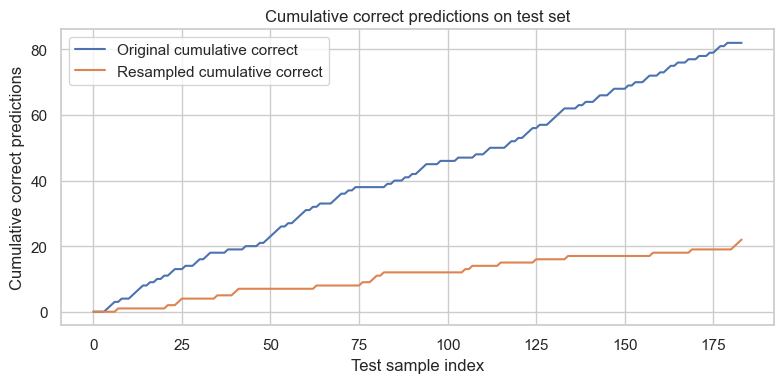

In [ ]:
#Add the contextual-bandits evaluation pieces

import numpy as np
import pandas as pd
from statsmodels.stats.proportion import proportions_ztest
from sklearn.metrics import accuracy_score, recall_score
import matplotlib.pyplot as plt

def get_protected_col(df, prefer="sex_Male"):
    if prefer in df.columns: 
        return df[prefer].values
    if "sex" in df.columns:
        return df["sex"].values
    return None

# 1) Predictions on train sets (greedy)
preds_train_orig = np.array([agent_orig.act(X_train_orig[i], greedy=True) for i in range(len(X_train_orig))])
preds_train_res  = np.array([agent_res.act(X_train_res[i], greedy=True)  for i in range(len(X_train_res))])

# Build DataFrames for easy group metrics
df_train_orig = X_train_orig_df.copy()
df_train_orig["true"] = y_train_orig
df_train_orig["pred"] = preds_train_orig

df_train_res = Xy_train_res_df.copy()
df_train_res["true"] = y_train_res
df_train_res["pred"] = preds_train_res

# Protected attribute detection
prot_col_train_orig = get_protected_col(df_train_orig)
prot_col_train_res  = get_protected_col(df_train_res)
prot_col_test       = get_protected_col(X_test_df)

# 2) Group metrics function
def group_metrics_df(df, prot_col_name):
    res = {}
    if prot_col_name is None or prot_col_name not in df.columns:
        return {"overall": {"n": len(df), "accuracy": accuracy_score(df["true"], df["pred"])}}
    for g in sorted(df[prot_col_name].unique()):
        grp = df[df[prot_col_name] == g]
        res[str(g)] = {
            "n": int(len(grp)),
            "accuracy": float(accuracy_score(grp["true"], grp["pred"])),
            "macro_recall": float(recall_score(grp["true"], grp["pred"], average="macro", zero_division=0))
        }
    return res

# 3) Print train/test sex-disaggregated metrics
print("== Train original sex-disaggregated ==")
print(group_metrics_df(df_train_orig, "sex_Male" if "sex_Male" in df_train_orig.columns else ("sex" if "sex" in df_train_orig.columns else None)))
print("\n== Train resampled sex-disaggregated ==")
print(group_metrics_df(df_train_res, "sex_Male" if "sex_Male" in df_train_res.columns else ("sex" if "sex" in df_train_res.columns else None)))

print("\n== Test sex-disaggregated (original model) ==")
df_test = X_test_df.copy()
df_test["true"] = y_test
df_test["pred_orig"] = res_orig["preds"]
df_test["pred_res"]  = res_res["preds"]
print("Original model:")
print(group_metrics_df(df_test.assign(pred=df_test["pred_orig"]), "sex_Male" if "sex_Male" in df_test.columns else ("sex" if "sex" in df_test.columns else None)))
print("Resampled model:")
print(group_metrics_df(df_test.assign(pred=df_test["pred_res"]), "sex_Male" if "sex_Male" in df_test.columns else ("sex" if "sex" in df_test.columns else None)))

# 4) Statistical z-test for sex accuracy difference on test (original vs resampled independent)
def sex_ztest_accuracy(df, pred_col, prot_col="sex_Male"):
    if prot_col not in df.columns:
        print("No protected column for z-test:", prot_col); return
    mask_m = df[prot_col] == 1
    mask_f = df[prot_col] == 0
    acc_m = (df.loc[mask_m, pred_col] == df.loc[mask_m, "true"]).astype(int)
    acc_f = (df.loc[mask_f, pred_col] == df.loc[mask_f, "true"]).astype(int)
    count = np.array([acc_m.sum(), acc_f.sum()])
    nobs = np.array([len(acc_m), len(acc_f)])
    stat, pval = proportions_ztest(count, nobs)
    print(f"Z-test ({pred_col}): z={stat:.3f}, p={pval:.5f}  counts={count}, nobs={nobs}")

print("\n== Sex z-tests (test set) ==")
sex_ztest_accuracy(df_test, "pred_orig")
sex_ztest_accuracy(df_test, "pred_res")

# 5) Age-group metrics & z-tests (uses ../data/age_analysis/Xy_test_age_analysis.csv)
age_test_path = os.path.join(DATA_DIR, "age_analysis", "Xy_test_age_analysis.csv")
if os.path.exists(age_test_path):
    df_age = pd.read_csv(age_test_path).rename(columns={"num":"true"})
    # attach predictions (ensure same row order)
    df_age["pred_orig"] = res_orig["preds"]
    df_age["pred_res"]  = res_res["preds"]
    print("\n== Age-group metrics (original model) ==")
    for g in df_age["age_group"].unique():
        mask = df_age["age_group"] == g
        acc = accuracy_score(df_age.loc[mask,"true"], df_age.loc[mask,"pred_orig"])
        f1 = f1_score(df_age.loc[mask,"true"], df_age.loc[mask,"pred_orig"], average="macro", zero_division=0)
        print(f"{g}: n={mask.sum()}, acc={acc:.3f}, macro_f1={f1:.3f}")
    # z-tests for consecutive groups (accuracy)
    ordered = sorted(df_age["age_group"].unique()) 
    print("\nAge-group consecutive z-tests (original model):")
    for i in range(len(ordered)-1):
        g1, g2 = ordered[i], ordered[i+1]
        m1 = df_age["age_group"] == g1
        m2 = df_age["age_group"] == g2
        acc1 = (df_age.loc[m1,"pred_orig"] == df_age.loc[m1,"true"]).astype(int)
        acc2 = (df_age.loc[m2,"pred_orig"] == df_age.loc[m2,"true"]).astype(int)
        count = np.array([acc1.sum(), acc2.sum()])
        nobs = np.array([len(acc1), len(acc2)])
        stat, pval = proportions_ztest(count, nobs)
        print(f"{g1} vs {g2}: z={stat:.3f}, p={pval:.5f}")

else:
    print("No age_analysis file found at:", age_test_path)

# 6) Simple cumulative-correct plot for test set (compare models)
corr_orig = (res_orig["preds"] == y_test).astype(int)
corr_res  = (res_res["preds"]  == y_test).astype(int)
plt.figure(figsize=(8,4))
plt.plot(np.cumsum(corr_orig), label="Original cumulative correct")
plt.plot(np.cumsum(corr_res),  label="Resampled cumulative correct")
plt.legend()
plt.xlabel("Test sample index")
plt.ylabel("Cumulative correct predictions")
plt.title("Cumulative correct predictions on test set")
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
from statsmodels.stats.proportion import proportions_ztest

preds_orig = res_orig["preds"]
preds_res  = res_res["preds"]

# 1️⃣ Load the test CSV with age groups
test_csv_path = "../data/age_analysis/Xy_test_age_analysis.csv"
df_test = pd.read_csv(test_csv_path)

# 2️⃣ Attach DQN predictions (make sure preds_orig or preds_res exist)
df_test.rename(columns={'num': 'true'}, inplace=True)
df_test['pred'] = preds_orig  # or preds_res for the resampled model

# 3️⃣ Compute metrics per age group
results = {}
for group in df_test['age_group'].unique():
    mask = df_test['age_group'] == group
    y_true = df_test.loc[mask, 'true']
    y_pred = df_test.loc[mask, 'pred']
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    results[group] = {'accuracy': acc, 'macro_f1': f1}

age_results = pd.DataFrame(results).T
print("Metrics by age group:")
print(age_results)

# 4️⃣ Perform z-tests for consecutive age groups (accuracy significance)
age_groups_ordered = ['<40', '40-50', '50-60', '60+']
for i in range(len(age_groups_ordered)-1):
    g1, g2 = age_groups_ordered[i], age_groups_ordered[i+1]
    mask_1 = df_test['age_group'] == g1
    mask_2 = df_test['age_group'] == g2
    acc_1 = (df_test.loc[mask_1, 'pred'] == df_test.loc[mask_1, 'true']).astype(int)
    acc_2 = (df_test.loc[mask_2, 'pred'] == df_test.loc[mask_2, 'true']).astype(int)
    
    count = np.array([acc_1.sum(), acc_2.sum()])
    nobs = np.array([len(acc_1), len(acc_2)])
    stat, pval = proportions_ztest(count, nobs)
    print(f"\nComparing {g1} vs {g2}: z = {stat:.3f}, p = {pval:.10f}")
    if pval < 0.05:
        print("Accuracy difference significant")
    else:
        print("Accuracy difference NOT significant")


Metrics by age group:
       accuracy  macro_f1
<40    0.666667  0.400000
60+    0.260000  0.082540
50-60  0.437500  0.121739
40-50  0.611111  0.189655

Comparing <40 vs 40-50: z = 0.399, p = 0.6902419821
Accuracy difference NOT significant

Comparing 40-50 vs 50-60: z = 1.730, p = 0.0835639452
Accuracy difference NOT significant

Comparing 50-60 vs 60+: z = 2.040, p = 0.0413305308
Accuracy difference significant


### Graphics

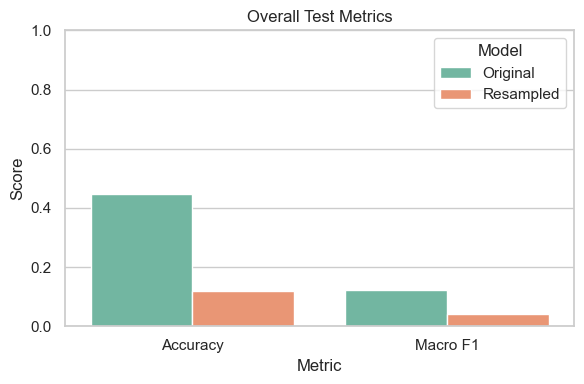

In [ ]:
#A simple bar chart comparing accuracy and macro F1 for the original and resampled DQN models.

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

overall_df = pd.DataFrame({
    "Model": ["Original", "Resampled"],
    "Accuracy": [res_orig["accuracy"], res_res["accuracy"]],
    "Macro F1": [res_orig["macro_f1"], res_res["macro_f1"]]
})

overall_df_melt = overall_df.melt(id_vars="Model", var_name="Metric", value_name="Score")

plt.figure(figsize=(6,4))
sns.barplot(data=overall_df_melt, x="Metric", y="Score", hue="Model", palette="Set2")
plt.title("Overall Test Metrics")
plt.ylim(0,1)
plt.ylabel("Score")
plt.tight_layout()
plt.show()


/var/folders/7g/k85gr2ds09vdkh_4yqmhgrkr0000gn/T/ipykernel_48465/3020974098.py:24: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=sex_df, x="Sex", y="Score", hue="Model", palette="Set1", ci=None)


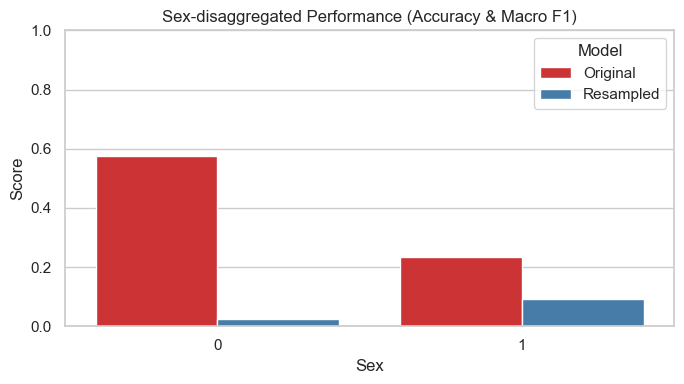

In [ ]:
#Grouped bar chart showing accuracy and macro F1 by sex for both models.

sex_metrics = []

for g, met in res_orig["metrics_by_sex"].items():
    sex_metrics.append({
        "Model": "Original",
        "Sex": g,
        "Accuracy": met["accuracy"],
        "Macro F1": met["macro_f1"]
    })

for g, met in res_res["metrics_by_sex"].items():
    sex_metrics.append({
        "Model": "Resampled",
        "Sex": g,
        "Accuracy": met["accuracy"],
        "Macro F1": met["macro_f1"]
    })

sex_df = pd.DataFrame(sex_metrics).melt(id_vars=["Model","Sex"], var_name="Metric", value_name="Score")

plt.figure(figsize=(7,4))
sns.barplot(data=sex_df, x="Sex", y="Score", hue="Model", palette="Set1", ci=None)
plt.title("Sex-disaggregated Performance (Accuracy & Macro F1)")
plt.ylim(0,1)
plt.ylabel("Score")
plt.tight_layout()
plt.show()


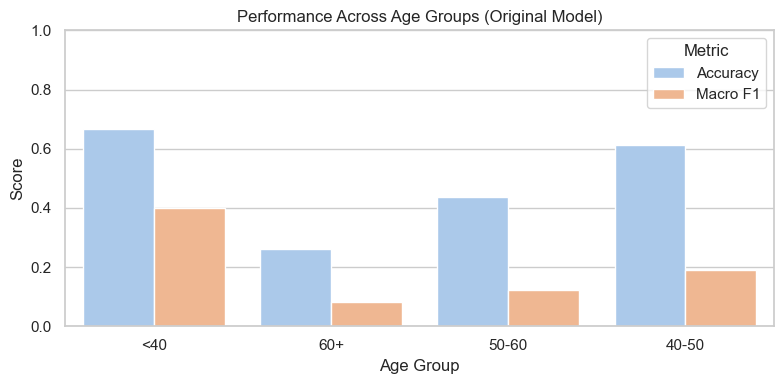

In [ ]:
#Another grouped bar chart for age bins, showing model performance across age groups.

# Build age results for plotting
age_metrics = []

for g, row in age_results.iterrows():
    age_metrics.append({
        "Age Group": g,
        "Model": "Original",
        "Accuracy": row["accuracy"],
        "Macro F1": row["macro_f1"]
    })

# If you also have age results for resampled model, repeat same way

age_df = pd.DataFrame(age_metrics).melt(id_vars=["Model","Age Group"], var_name="Metric", value_name="Score")

plt.figure(figsize=(8,4))
sns.barplot(data=age_df, x="Age Group", y="Score", hue="Metric", palette="pastel")
plt.title("Performance Across Age Groups (Original Model)")
plt.ylim(0,1)
plt.ylabel("Score")
plt.tight_layout()
plt.show()


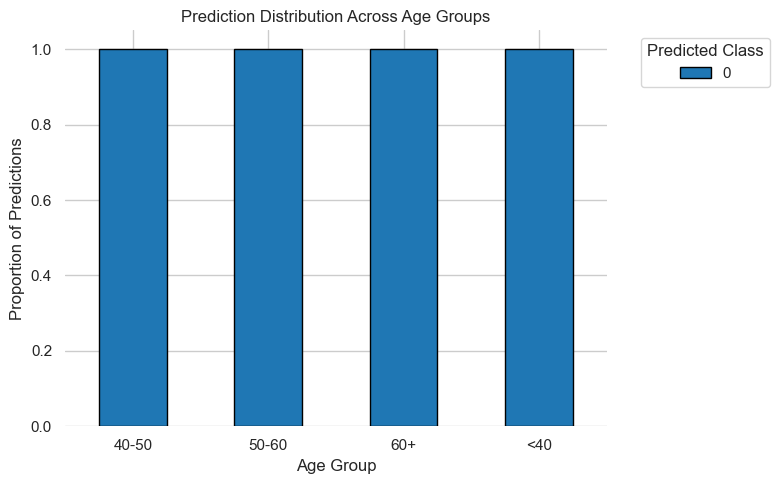

In [ ]:
#A stacked bar plot showing the predicted class distribution per group (sex or age). This helps highlight bias or skew.

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Make sure 'pred' is categorical
df_test['pred'] = df_test['pred'].astype(str)  # or use Categorical for ordered classes

# Compute proportion of predictions per age group
age_group_pred_dist = df_test.groupby("age_group")["pred"].value_counts(normalize=True).unstack().fillna(0)

# Plot
fig, ax = plt.subplots(figsize=(8,5))
age_group_pred_dist.plot(
    kind="bar",
    stacked=True,
    ax=ax,
    colormap="tab20",
    edgecolor='black'
)

# Improve labels and aesthetics
ax.set_ylabel("Proportion of Predictions")
ax.set_xlabel("Age Group")
ax.set_title("Prediction Distribution Across Age Groups")
ax.legend(title="Predicted Class", bbox_to_anchor=(1.05,1), loc='upper left')
sns.despine(left=True, bottom=True)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()



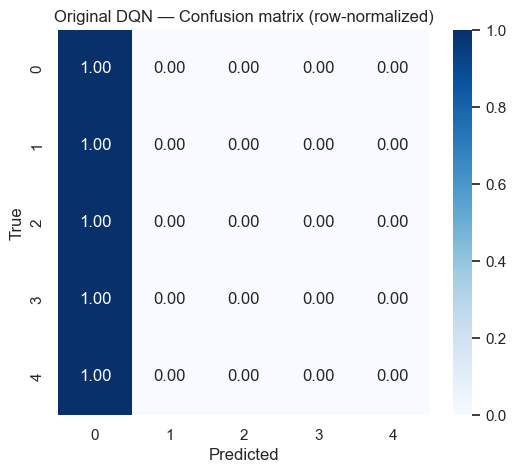

,precision,recall,f1,support
0,0.445652,1.0,0.616541,82
1,0.000000,0.0,0.000000,53
2,0.000000,0.0,0.000000,22
3,0.000000,0.0,0.000000,21
4,0.000000,0.0,0.000000,6


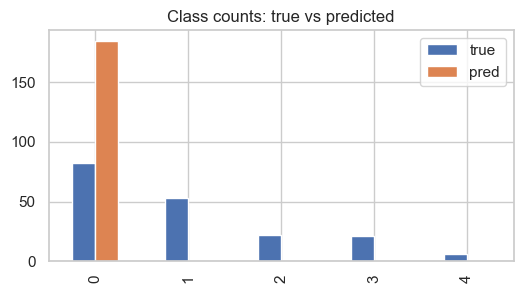

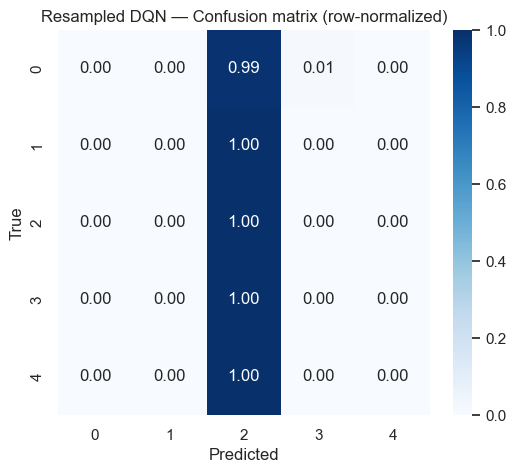

,precision,recall,f1,support
0,0.000000,0.0,0.000000,82
1,0.000000,0.0,0.000000,53
2,0.120219,1.0,0.214634,22
3,0.000000,0.0,0.000000,21
4,0.000000,0.0,0.000000,6


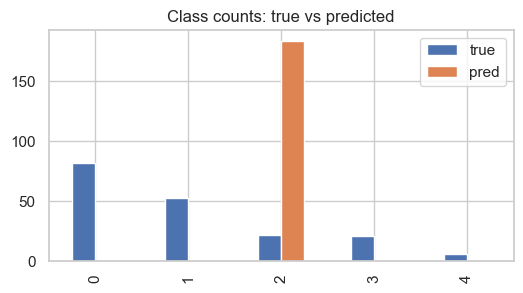

In [ ]:
# ...existing code...
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

def plot_confusion_and_class_metrics(y_true, y_pred, labels=None, title=""):
    cm = confusion_matrix(y_true, y_pred, labels=labels, normalize='true')
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted"); plt.ylabel("True"); plt.title(title + " — Confusion matrix (row-normalized)")
    plt.show()

    p, r, f1, sup = precision_recall_fscore_support(y_true, y_pred, labels=labels, zero_division=0)
    df = pd.DataFrame({"precision": p, "recall": r, "f1": f1, "support": sup}, index=labels)
    display(df)

    # class distribution true vs pred
    true_counts = pd.Series(y_true).value_counts().sort_index()
    pred_counts = pd.Series(y_pred).value_counts().sort_index()
    dist_df = pd.DataFrame({"true": true_counts, "pred": pred_counts}).fillna(0)
    dist_df.plot(kind="bar", figsize=(6,3))
    plt.title("Class counts: true vs predicted")
    plt.show()

labels = list(range(NUM_ACTIONS))
plot_confusion_and_class_metrics(y_test, res_orig["preds"], labels=labels, title="Original DQN")
plot_confusion_and_class_metrics(y_test, res_res["preds"], labels=labels, title="Resampled DQN")
# ...existing code...

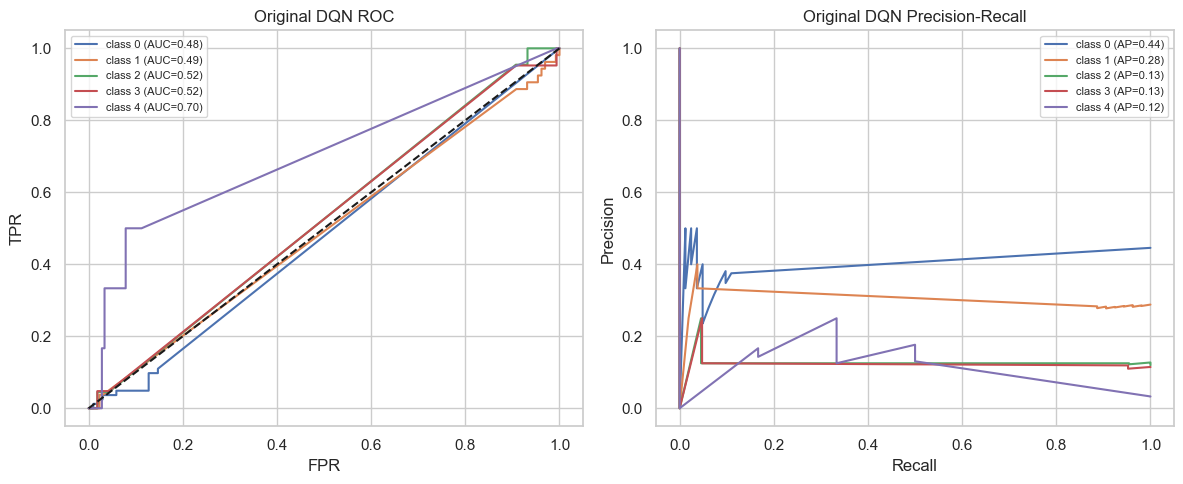

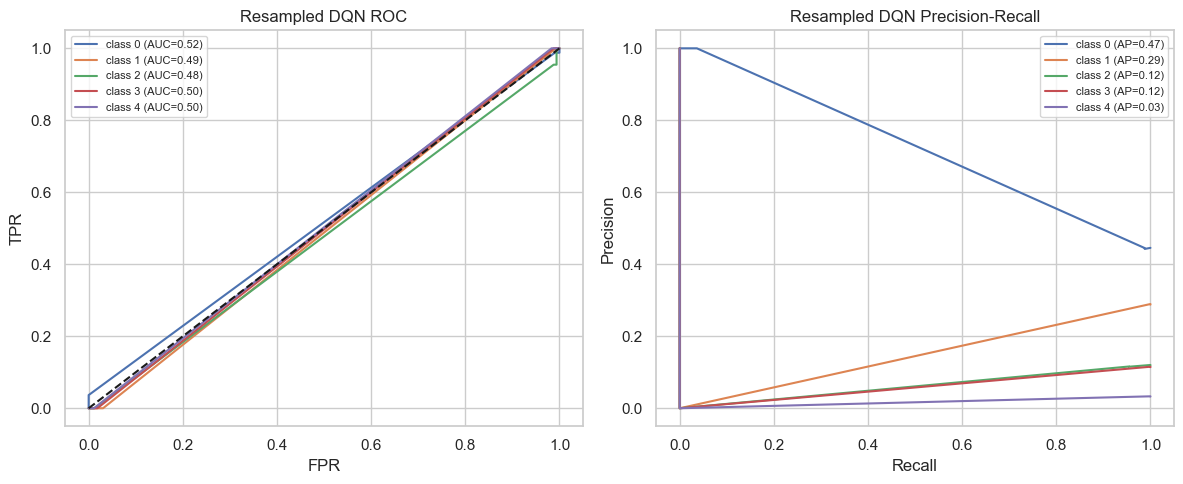

In [ ]:
# ...existing code...
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import itertools
import torch.nn.functional as F
from sklearn.preprocessing import label_binarize

def get_probs(agent, X):
    with torch.no_grad():
        logits = torch.stack([agent.q(torch.tensor(x, dtype=torch.float32)) for x in X])
        probs = F.softmax(logits, dim=1).cpu().numpy()
    return probs

probs_orig = get_probs(agent_orig, X_test)
probs_res  = get_probs(agent_res,  X_test)
y_bin = label_binarize(y_test, classes=list(range(NUM_ACTIONS)))

def plot_roc_pr(probs, y_bin, model_name=""):
    plt.figure(figsize=(12,5))
    # ROC per class
    plt.subplot(1,2,1)
    for i in range(y_bin.shape[1]):
        fpr, tpr, _ = roc_curve(y_bin[:,i], probs[:,i])
        plt.plot(fpr, tpr, label=f"class {i} (AUC={auc(fpr,tpr):.2f})")
    plt.plot([0,1],[0,1],"k--"); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title(model_name+" ROC")
    plt.legend(loc="best", fontsize=8)

    # PR per class
    plt.subplot(1,2,2)
    for i in range(y_bin.shape[1]):
        prec, rec, _ = precision_recall_curve(y_bin[:,i], probs[:,i])
        ap = average_precision_score(y_bin[:,i], probs[:,i])
        plt.plot(rec, prec, label=f"class {i} (AP={ap:.2f})")
    plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title(model_name+" Precision-Recall")
    plt.legend(loc="best", fontsize=8)
    plt.tight_layout()
    plt.show()

plot_roc_pr(probs_orig, y_bin, "Original DQN")
plot_roc_pr(probs_res,  y_bin, "Resampled DQN")
# ...existing code...

In [ ]:
# ===== Save trained agents for sharing =====
import pickle
import torch
import os

out_dir = "../data"  # same directory you used for models
os.makedirs(out_dir, exist_ok=True)

# Save original DQN
orig_model_pth = os.path.join(out_dir, "dqn_original.pth")
orig_model_pkl = os.path.join(out_dir, "dqn_original.pkl")
torch.save(agent_orig.q.state_dict(), orig_model_pth)
with open(orig_model_pkl, "wb") as f:
    pickle.dump(agent_orig.q.cpu(), f)
print(f"Original agent saved -> {orig_model_pth}, {orig_model_pkl}")

# Save resampled DQN
res_model_pth = os.path.join(out_dir, "dqn_resampled.pth")
res_model_pkl = os.path.join(out_dir, "dqn_resampled.pkl")
torch.save(agent_res.q.state_dict(), res_model_pth)
with open(res_model_pkl, "wb") as f:
    pickle.dump(agent_res.q.cpu(), f)
print(f"Resampled agent saved -> {res_model_pth}, {res_model_pkl}")

# ===== Usage for Niko =====
# He can load with:
# import pickle, torch
# from your_dqn_class_file import DQNAgent
# q_net = pickle.load(open("dqn_original.pkl","rb"))
# agent = DQNAgent(state_dim=STATE_DIM, n_actions=NUM_ACTIONS)
# agent.q.load_state_dict(q_net.state_dict())


Original agent saved -> ../data/dqn_original.pth, ../data/dqn_original.pkl
Resampled agent saved -> ../data/dqn_resampled.pth, ../data/dqn_resampled.pkl


In [ ]:
# import torch
# import pickle
# import numpy as np
# from sklearn.metrics import accuracy_score, f1_score

# # Paths
# MODEL_ORIG_PKL = "../data/dqn_original.pkl"
# MODEL_RES_PKL  = "../data/dqn_resampled.pkl"

# # Load agents
# with open(MODEL_ORIG_PKL, "rb") as f:
#     agent_orig_q = pickle.load(f)
# with open(MODEL_RES_PKL, "rb") as f:
#     agent_res_q = pickle.load(f)

# # Define minimal agent wrapper to use .act()
# class AgentWrapper:
#     def __init__(self, q_net):
#         self.q = q_net
#         self.eps = 0.0
#     def act(self, state, greedy=True):
#         state = torch.tensor(state, dtype=torch.float32)
#         with torch.no_grad():
#             return int(torch.argmax(self.q(state)).item())

# agent_orig = AgentWrapper(agent_orig_q)
# agent_res  = AgentWrapper(agent_res_q)

# # Evaluate on test set
# preds_orig = np.array([agent_orig.act(X_test[i]) for i in range(len(X_test))])
# preds_res  = np.array([agent_res.act(X_test[i])  for i in range(len(X_test))])

# # Optional: sex metrics
# def metrics_by_sex(y_true, y_pred, sex_col):
#     res = {}
#     for g in np.unique(sex_col):
#         mask = sex_col == g
#         res[str(g)] = {
#             "accuracy": accuracy_score(y_true[mask], y_pred[mask]),
#             "macro_f1": f1_score(y_true[mask], y_pred[mask], average="macro")
#         }
#     return res

# test_sex = X_test_df['sex_Male'].values if 'sex_Male' in X_test_df.columns else None
# res_orig = {"preds": preds_orig, "metrics_by_sex": metrics_by_sex(y_test, preds_orig, test_sex)}
# res_res  = {"preds": preds_res,  "metrics_by_sex": metrics_by_sex(y_test, preds_res,  test_sex)}


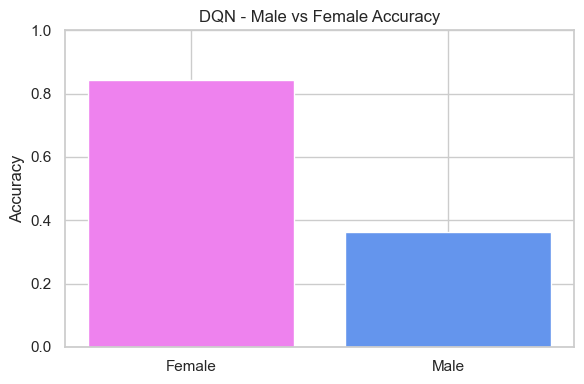

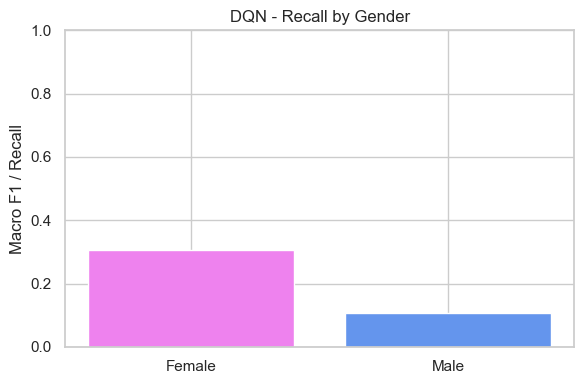

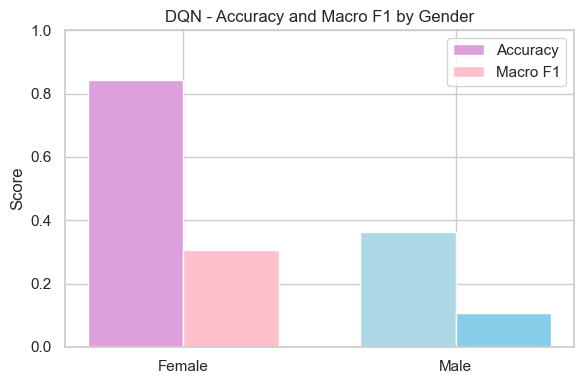

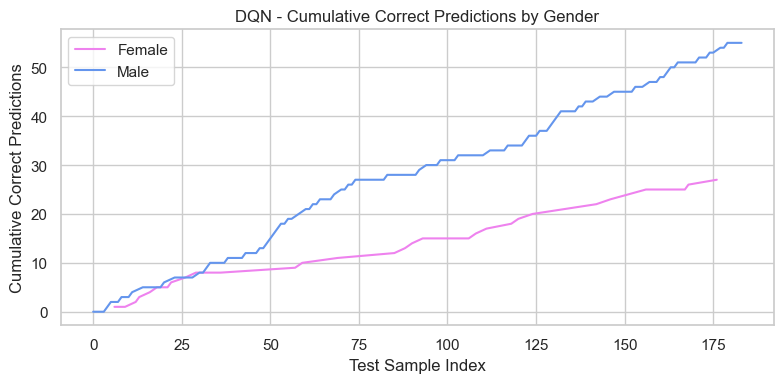

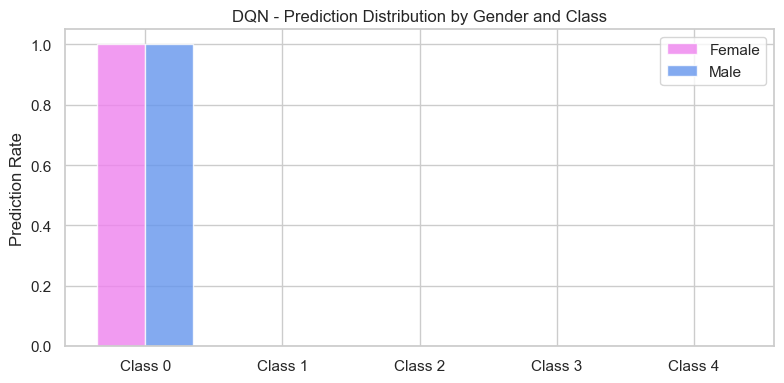

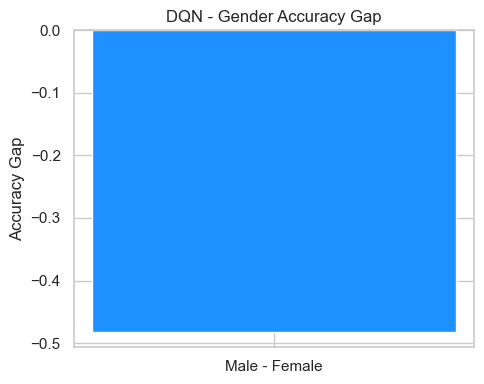

/Users/ellaforss/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ellaforss/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


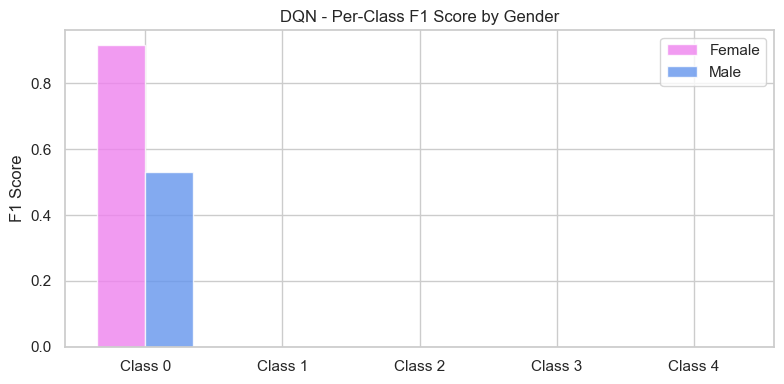

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

# =========================
# 1️⃣ Prepare DataFrames
# =========================

df_test = X_test_df.copy()
df_test['true'] = y_test
df_test['pred'] = res_orig["preds"]

test_sex = df_test['sex_Male'].values if 'sex_Male' in df_test.columns else None

# Age group metrics
age_results = {}
if 'age_group' in df_test.columns:
    for group in df_test['age_group'].unique():
        mask = df_test['age_group'] == group
        y_true = df_test.loc[mask, 'true']
        age_results[group] = {
            'accuracy': accuracy_score(y_true, df_test.loc[mask, 'pred']),
            'macro_f1': f1_score(y_true, df_test.loc[mask, 'pred'], average='macro')
        }
age_results_df = pd.DataFrame(age_results).T.reset_index().rename(columns={'index':'age_group'})

colors = ['violet', 'cornflowerblue']


# =========================
# 2️⃣ Male vs Female Accuracy
# =========================
if test_sex is not None:
    sex_groups = ['Female','Male']
    acc = [accuracy_score(y_test[test_sex==0], df_test['pred'][test_sex==0]),
           accuracy_score(y_test[test_sex==1], df_test['pred'][test_sex==1])]

    x = np.arange(len(sex_groups))
    plt.figure(figsize=(6,4))
    plt.bar(x, acc, color=colors)
    plt.xticks(x, sex_groups)
    plt.ylabel("Accuracy")
    plt.title("DQN - Male vs Female Accuracy")
    plt.ylim(0,1)
    plt.tight_layout()
    plt.show()

# =========================
# 3️⃣ Accuracy by Age Group
# =========================
if not age_results_df.empty:
    x = np.arange(len(age_results_df))
    plt.figure(figsize=(8,4))
    plt.bar(x, age_results_df['accuracy'], color='cornfloweblue')
    plt.xticks(x, age_results_df['age_group'])
    plt.ylabel("Accuracy")
    plt.xlabel("Age Group")
    plt.title("DQN - Accuracy by Age Group")
    plt.ylim(0,1)
    plt.tight_layout()
    plt.show()

# =========================
# 4️⃣ Recall / Macro F1 by Gender
# =========================
if test_sex is not None:
    recall = [f1_score(y_test[test_sex==0], df_test['pred'][test_sex==0], average='macro'),
              f1_score(y_test[test_sex==1], df_test['pred'][test_sex==1], average='macro')]

    x = np.arange(len(sex_groups))
    plt.figure(figsize=(6,4))
    plt.bar(x, recall, color=colors)
    plt.xticks(x, sex_groups)
    plt.ylabel("Macro F1 / Recall")
    plt.title("DQN - Recall by Gender")
    plt.ylim(0,1)
    plt.tight_layout()
    plt.show()

# Ensure predictions are in df_test
df_test['pred'] = res_orig["preds"]

if 'sex_Male' in df_test.columns:
    sex_groups = ['Female', 'Male']

    # Compute Accuracy
    acc = [
        accuracy_score(df_test['true'][df_test['sex_Male']==0], df_test['pred'][df_test['sex_Male']==0]),
        accuracy_score(df_test['true'][df_test['sex_Male']==1], df_test['pred'][df_test['sex_Male']==1])
    ]

    # Compute Macro F1
    f1 = [
        f1_score(df_test['true'][df_test['sex_Male']==0], df_test['pred'][df_test['sex_Male']==0], average='macro'),
        f1_score(df_test['true'][df_test['sex_Male']==1], df_test['pred'][df_test['sex_Male']==1], average='macro')
    ]

    # Colors
    colors_acc = ['plum', 'lightblue']
    colors_f1  = ['pink', 'skyblue']

    # Plot grouped bar chart
    x = np.arange(len(sex_groups))
    width = 0.35
    plt.figure(figsize=(6,4))
    plt.bar(x - width/2, acc, width, color=colors_acc, label='Accuracy')
    plt.bar(x + width/2, f1, width, color=colors_f1, label='Macro F1')
    plt.xticks(x, sex_groups)
    plt.ylim(0,1)
    plt.ylabel("Score")
    plt.title("DQN - Accuracy and Macro F1 by Gender")
    plt.legend()
    plt.tight_layout()
    plt.show()


# =========================
# 5️⃣ Cumulative Correct Predictions by Gender
# =========================
if test_sex is not None:
    plt.figure(figsize=(8,4))
    for g, label, c in zip([0,1], sex_groups, colors):
        cum_correct = np.cumsum((df_test['pred'][test_sex==g] == y_test[test_sex==g]).astype(int))
        plt.plot(cum_correct, label=label, color=c)
    plt.xlabel("Test Sample Index")
    plt.ylabel("Cumulative Correct Predictions")
    plt.title("DQN - Cumulative Correct Predictions by Gender")
    plt.legend()
    plt.tight_layout()
    plt.show()

# =========================
# 6️⃣ Prediction Distribution by Class and Gender
# =========================
num_classes = NUM_ACTIONS
pred_rate = []

for g in [0,1]:
    mask = test_sex == g
    rates = [(df_test['pred'][mask]==c).mean() for c in range(num_classes)]
    pred_rate.append(rates)

x = np.arange(num_classes)
width = 0.35
plt.figure(figsize=(8,4))
for i, label in enumerate(sex_groups):
    plt.bar(x + (i-0.5)*width, pred_rate[i], width, label=label, alpha=0.8, color=colors[i])
plt.xticks(x, [f'Class {c}' for c in range(num_classes)])
plt.ylabel("Prediction Rate")
plt.title("DQN - Prediction Distribution by Gender and Class")
plt.legend()
plt.tight_layout()
plt.show()

# =========================
# 7️⃣ Gender Accuracy Gap
# =========================
if test_sex is not None:
    acc_gap = accuracy_score(y_test[test_sex==1], df_test['pred'][test_sex==1]) - \
               accuracy_score(y_test[test_sex==0], df_test['pred'][test_sex==0])
    plt.figure(figsize=(5,4))
    plt.bar(['Male - Female'], [acc_gap], color='dodgerblue')
    plt.ylabel("Accuracy Gap")
    plt.title("DQN - Gender Accuracy Gap")
    plt.tight_layout()
    plt.show()

# =========================
# 8️⃣ Per-Class F1 by Gender
# =========================
f1_scores = []
for g in [0,1]:
    mask = test_sex==g
    f1_scores.append([f1_score((y_test[mask]==c).astype(int), (df_test['pred'][mask]==c).astype(int)) for c in range(num_classes)])

x = np.arange(num_classes)
plt.figure(figsize=(8,4))
for i, label in enumerate(sex_groups):
    plt.bar(x + (i-0.5)*width, f1_scores[i], width, label=label, alpha=0.8, color=colors[i])
plt.xticks(x, [f'Class {c}' for c in range(num_classes)])
plt.ylabel("F1 Score")
plt.title("DQN - Per-Class F1 Score by Gender")
plt.legend()
plt.tight_layout()
plt.show()



In [33]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
import os

# Load age analysis file
age_test_path = "../../data/age_analysis/Xy_test_age_analysis.csv"
if os.path.exists(age_test_path):
    df_age = pd.read_csv(age_test_path).rename(columns={"num": "true"})
    df_age['pred'] = res_orig["preds"]

    # ✅ Force age group ordering and labels
    ordered_groups = ["<=40", "41-50", "51-60", ">60"]
    df_age["age_group"] = pd.Categorical(df_age["age_group"], 
                                         categories=ordered_groups, 
                                         ordered=True)

    age_groups = [g for g in ordered_groups if g in df_age["age_group"].unique()]

    acc_by_age, f1_by_age, cum_correct_by_age, pred_rates_by_age = [], [], [], []

    for g in age_groups:
        mask = df_age['age_group'] == g
        y_true = df_age.loc[mask, 'true']
        y_pred = df_age.loc[mask, 'pred']

        acc_by_age.append(accuracy_score(y_true, y_pred))
        f1_by_age.append(f1_score(y_true, y_pred, average='macro'))
        cum_correct_by_age.append(np.cumsum((y_pred == y_true).astype(int)))
        pred_rates_by_age.append([(y_pred == c).mean() for c in range(NUM_ACTIONS)])

    # Colors for age groups
    age_colors = plt.cm.viridis(np.linspace(0.3, 0.8, len(age_groups)))

    # 🔹 Accuracy by Age Group
    plt.figure(figsize=(8,4))
    plt.bar(age_groups, acc_by_age, color=age_colors)
    plt.ylim(0,1)
    plt.ylabel("Accuracy")
    plt.xlabel("Age Group")
    plt.title("DQN - Accuracy by Age Group")
    plt.tight_layout()
    plt.show()

    # 🔹 Macro F1 by Age Group
    plt.figure(figsize=(8,4))
    plt.bar(age_groups, f1_by_age, color=age_colors)
    plt.ylim(0,1)
    plt.ylabel("Macro F1")
    plt.xlabel("Age Group")
    plt.title("DQN - Macro F1 by Age Group")
    plt.tight_layout()
    plt.show()

    # 🔹 Cumulative Correct Predictions
    plt.figure(figsize=(8,4))
    for g, cum_correct, c in zip(age_groups, cum_correct_by_age, age_colors):
        plt.plot(cum_correct, label=g, color=c)
    plt.xlabel("Test Sample Index")
    plt.ylabel("Cumulative Correct Predictions")
    plt.title("DQN - Cumulative Correct Predictions by Age Group")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 🔹 Prediction Distribution
    x = np.arange(NUM_ACTIONS)
    width = 0.7 / len(age_groups)
    plt.figure(figsize=(10,4))
    for i, (g, rates, c) in enumerate(zip(age_groups, pred_rates_by_age, age_colors)):
        plt.bar(x + (i - len(age_groups)/2) * width, rates, width, color=c, label=g)
    plt.xticks(x, [f'Class {c}' for c in range(NUM_ACTIONS)])
    plt.ylabel("Prediction Rate")
    plt.xlabel("Class")
    plt.title("DQN - Prediction Distribution by Age Group")
    plt.legend()
    plt.tight_layout()
    plt.show()

else:
    print("Age analysis file not found:", age_test_path)

# 🔹 Combined Accuracy + Macro F1 (simplified plot)
if os.path.exists(age_test_path):
    x = np.arange(len(age_groups))
    width = 0.35
    plt.figure(figsize=(8,4))
    plt.bar(x - width/2, acc_by_age, width, label="Accuracy", color='teal')
    plt.bar(x + width/2, f1_by_age, width, label="Macro F1", color='olive')
    plt.xticks(x, age_groups)
    plt.ylim(0,1)
    plt.xlabel("Age Group")
    plt.ylabel("Score")
    plt.title("DQN - Accuracy and Macro F1 by Age Group")
    plt.legend()
    plt.tight_layout()
    plt.show()


NameError: name 'res_orig' is not defined

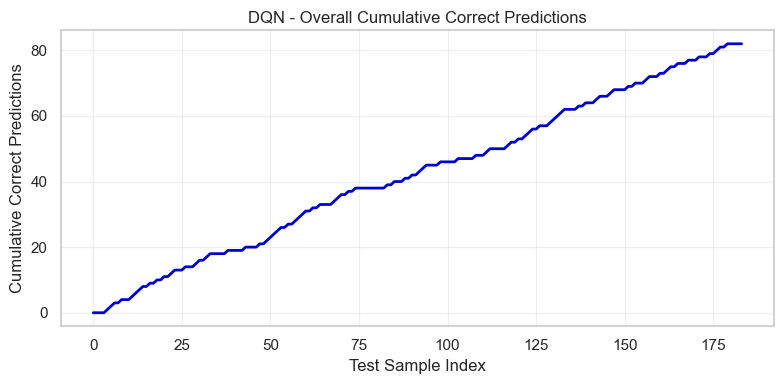

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Overall cumulative correct predictions (Original DQN)
cum_correct = np.cumsum((res_orig["preds"] == y_test).astype(int))

plt.figure(figsize=(8,4))
plt.plot(cum_correct, color='mediumblue', linewidth=2)
plt.xlabel("Test Sample Index")
plt.ylabel("Cumulative Correct Predictions")
plt.title("DQN - Overall Cumulative Correct Predictions")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


/var/folders/7g/k85gr2ds09vdkh_4yqmhgrkr0000gn/T/ipykernel_48465/2795983547.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=np.arange(NUM_ACTIONS), y=per_class_acc, palette="Blues")


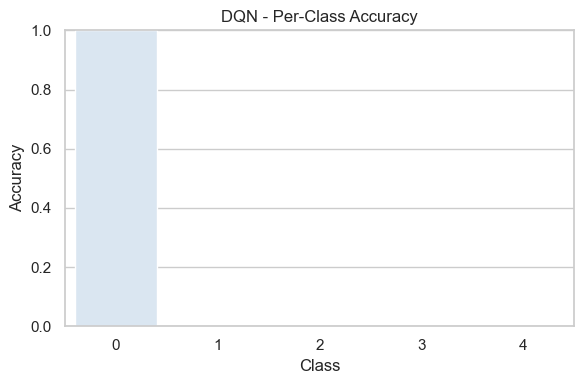

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, res_orig["preds"])
per_class_acc = cm.diagonal() / cm.sum(axis=1)

plt.figure(figsize=(6,4))
sns.barplot(x=np.arange(NUM_ACTIONS), y=per_class_acc, palette="Blues")
plt.xlabel("Class")
plt.ylabel("Accuracy")
plt.title("DQN - Per-Class Accuracy")
plt.ylim(0,1)
plt.tight_layout()
plt.show()


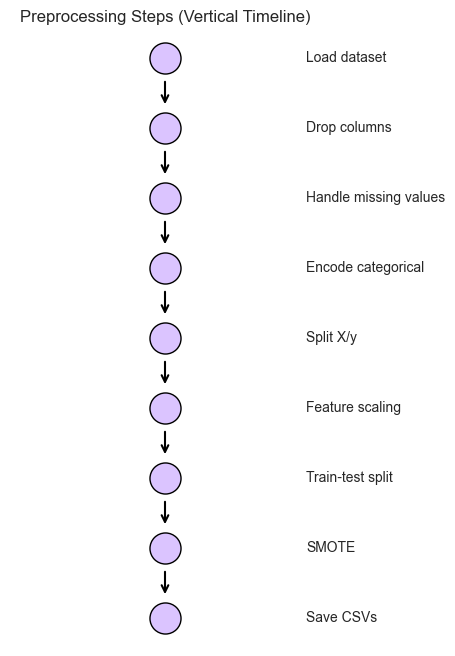

In [ ]:
fig, ax = plt.subplots(figsize=(4, 8))
ax.axis('off')

y = np.linspace(0.9, 0.1, len(steps))
x = np.ones_like(y)

for xi, yi, step in zip(x, y, steps):
    ax.scatter(xi, yi, s=500, color="#dbc4ff", edgecolor='black')
    ax.text(xi+0.05, yi, step, ha='left', va='center', fontsize=10)

# Arrows
for i in range(len(y)-1):
    ax.annotate("", xy=(1, y[i+1]+0.03), xytext=(1, y[i]-0.03),
                arrowprops=dict(arrowstyle="->", lw=1.5, color='black'))

plt.title("Preprocessing Steps (Vertical Timeline)")
plt.show()


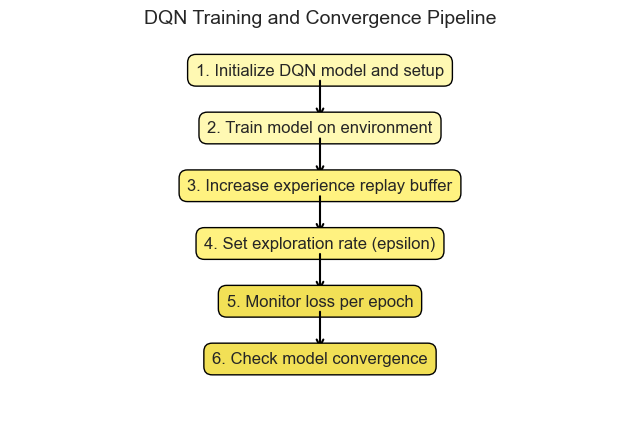

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 5))
ax.axis('off')

# DQN steps
steps = [
    "1. Initialize DQN model and setup",
    "2. Train model on environment",
    "3. Increase experience replay buffer",
    "4. Set exploration rate (epsilon)",
    "5. Monitor loss per epoch",
    "6. Check model convergence"
]

y_positions = [0.95, 0.80, 0.65, 0.50, 0.35, 0.20]

# Define shades: first 2 steps, next 2 steps, last 2 steps
colors = [
    "#fff9b3", "#fff9b3",  # light yellow 1
    "#fff280", "#fff280",  # light yellow 2
    "#f2e056", "#f2e056"   # light yellow 3
]

for i, (step, y, color) in enumerate(zip(steps, y_positions, colors)):
    ax.text(x=0.5, y=y, s=step, ha='center', va='center', fontsize=12,
            bbox=dict(boxstyle="round,pad=0.5", facecolor=color, edgecolor='black'))
    
    # Draw arrows between boxes
    if i < len(steps)-1:
        ax.annotate("", xy=(0.5, y_positions[i+1]+0.02), xytext=(0.5, y-0.02),
                    arrowprops=dict(arrowstyle="->", lw=1.5, color='black'))

plt.title("DQN Training and Convergence Pipeline", fontsize=14, pad=20)
plt.show()


In [32]:
import torch
import numpy as np

# Make sure X_test is a torch tensor
X_test_tensor = torch.tensor(X_test_df.values, dtype=torch.float32)

with torch.no_grad():
    q_values = agent_orig.q(X_test_tensor)  # forward pass
    preds_orig = torch.argmax(q_values, axis=1).numpy()  # predicted actions


NameError: name 'agent_orig' is not defined

In [31]:
# language: python
# Create age-group accuracy + F1 grouped bar chart
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score

sns.set(style="whitegrid")

# Choose which model preds to visualize: "original", "resampled", or provide array `preds`
model_choice = "original"  # or "resampled"
# prefer res_orig/res_res from notebook
if model_choice == "original" and 'res_orig' in globals():
    preds = np.asarray(res_orig["preds"]).ravel()
elif model_choice == "resampled" and 'res_res' in globals():
    preds = np.asarray(res_res["preds"]).ravel()
elif 'preds' in globals():
    preds = np.asarray(preds).ravel()
else:
    raise RuntimeError("No prediction array found (res_orig/res_res or preds).")

# Build test dataframe (use existing df_test if available)
if 'df_test' in globals():
    df = df_test.copy()
else:
    # fallback: use X_test_df and y_test
    df = X_test_df.copy()
    df['true'] = y_test
    df['pred'] = preds

# attach the chosen preds column
df['pred_model'] = preds if 'pred_model' not in df.columns else df['pred_model']

# Ensure age_group exists (create using desired bins)
desired_order = ['<=40', '41-50', '51-60', '>60']
if 'age_group' not in df.columns:
    if 'age' not in df.columns:
        raise RuntimeError("No 'age' column in test dataframe to build age groups.")
    bins = [0, 40, 50, 60, 200]
    labels = desired_order
    df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, include_lowest=True)

# Compute metrics per age group
rows = []
for grp in desired_order:
    mask = df['age_group'] == grp
    n = int(mask.sum())
    if n == 0:
        acc = np.nan
        f1 = np.nan
    else:
        acc = accuracy_score(df.loc[mask, 'true'], df.loc[mask, 'pred_model'])
        f1 = f1_score(df.loc[mask, 'true'], df.loc[mask, 'pred_model'], average='macro', zero_division=0)
    rows.append({'age_group': grp, 'n': n, 'accuracy': acc, 'macro_f1': f1})

metrics_df = pd.DataFrame(rows).set_index('age_group')

# Plot grouped bars (accuracy + F1)
plt.figure(figsize=(8,4))
x = np.arange(len(metrics_df))
width = 0.35
plt.bar(x - width/2, metrics_df['accuracy'], width, label='Accuracy', color='#4C72B0')
plt.bar(x + width/2, metrics_df['macro_f1'], width, label='Macro F1', color='#DD8452')

# annotate counts and values
for i, (acc, f1, n) in enumerate(zip(metrics_df['accuracy'], metrics_df['macro_f1'], metrics_df['n'])):
    if not np.isnan(acc):
        plt.text(i - width/2, acc + 0.01, f"{acc:.2f}", ha='center', va='bottom', fontsize=9)
    if not np.isnan(f1):
        plt.text(i + width/2, f1 + 0.01, f"{f1:.2f}", ha='center', va='bottom', fontsize=9)
    plt.text(i, -0.05, f"n={n}", ha='center', va='top', fontsize=9)  # sample counts under x-axis

plt.xticks(x, metrics_df.index)
plt.ylim(-0.08, 1.05)
plt.ylabel('Score')
plt.title(f'Age-group performance ({model_choice})')
plt.legend()
plt.tight_layout()
plt.show()

# show metrics table
print(metrics_df)

RuntimeError: No prediction array found (res_orig/res_res or preds).